In [1]:
import geemap.colormaps as cm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [3]:
import ee
import folium
import geemap
import geopandas as gpd
import numpy as np 
import pandas as pd 
import proplot as plot 
import matplotlib.pyplot as plt 
from ipygee import*
from pandas.plotting import register_matplotlib_converters
pd.set_option("display.max_rows", 10000, "display.max_columns", 1000)
try:
    import geemap, ee, folium
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap
    else:
        print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
    import geemap, ee
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()
center_lat = 45
center_lon = 45
zoomlevel=6
Map = geemap.Map(center=[center_lat,center_lon], zoom=zoomlevel)

In [4]:
#aoi
shp_aoi = geemap.shp_to_ee('/Users/christianabys/Desktop/School/Maryland/Research/Wheat_Forecast/Random_Mask/training/16_20_wint_mask.shp')
Map.addLayer(shp_aoi, {}, 'aoi')

In [5]:
#collect image
modis_ndvi = ee.ImageCollection('MODIS/006/MOD13Q1') \
        .filterDate(ee.DateRange('2016-01-01','2021-01-01')) \
        .select('NDVI')
modis_evi = ee.ImageCollection('MODIS/006/MOD13Q1') \
        .filterDate(ee.DateRange('2016-01-01','2021-01-01')) \
        .select('EVI')
#scale factor
def scale_factor(image):
    return image.multiply(0.0001).copyProperties(image,['system:time_start'])
#apply scale factor
image_ndvi = modis_ndvi.map(scale_factor)
image_evi = modis_evi.map(scale_factor)
#convert image collection to image
image_ndvi = image_ndvi.toBands()
image_evi = image_evi.toBands()

palette = cm.palettes.ndvi

ndvi_vis = {'min': 0.0,
         'max': 9000.0,
         'palette':palette
         }
evi_vis = {'min': 0.0,
         'max': 9000.0,
         'palette':palette
         }

Map.addLayer(image_ndvi,{},'MODIS NDVI TIME SERIES')
Map.addLayer(image_ndvi.select(0),ndvi_vis,'MODIS NDVI VIS')
Map.addLayer(image_evi,{},'MODIS EVI TIME SERIES')
Map.addLayer(image_evi.select(0),evi_vis,'MODIS EVI VIS')
Map

Map(center=[45, 45], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

In [7]:
#set reducer
Map.set_plot_options(add_marker_cluster = True, marker = None)
Map.roi_reducer = ee.Reducer.mean()

In [8]:
output_csv_path_ndvi ='/Users/christianabys/Desktop/School/Maryland/Research/Wheat_Forecast/Random_Mask/pixel_ndvi.csv'
#key built in feature extract values to points
geemap.extract_values_to_points(shp_aoi,image_ndvi,output_csv_path_ndvi)

output_csv_path_evi = '/Users/christianabys/Desktop/School/Maryland/Research/Wheat_Forecast/Random_Mask/pixel_evi.csv'
geemap.extract_values_to_points(shp_aoi,image_evi,output_csv_path_evi)

Generating URL ...
Please wait ...
Data downloaded to /Users/christianabys/Desktop/School/Maryland/Research/Wheat_Forecast/Random_Mask/pixel_ndvi.csv
Generating URL ...
Please wait ...
Data downloaded to /Users/christianabys/Desktop/School/Maryland/Research/Wheat_Forecast/Random_Mask/pixel_evi.csv


In [9]:
#pixel analysis NDVI
#load in csv and set ID
pix_ndvi = pd.read_csv('/Users/christianabys/Desktop/School/Maryland/Research/Wheat_Forecast/Random_Mask/pixel_ndvi.csv')
pix_ndvi = pix_ndvi.set_index('id').drop(columns = ['system:index','year_wm'])
#rename Column values and replace with dash for datetime conversion 
pix_ndvi = pix_ndvi.rename(columns = lambda x: x[:10])
pix_ndvi.columns = pix_ndvi.columns.str.replace('_','-')
#transpose for Time Series
pix_ndvi = pix_ndvi.T
#make id a column
pix_ndvi = pix_ndvi.reset_index()
#make index column to datetime
pix_ndvi['index'] = pd.to_datetime(pix_ndvi['index'])
pix_ndvi = pix_ndvi.rename(columns = {"index":'Date'})
#create month column for classifying
pix_ndvi['month'] = pd.DatetimeIndex(pix_ndvi['Date']).month
pix_ndvi['year'] = pd.DatetimeIndex(pix_ndvi['Date']).year

#pixel analysis EVI
#load in csv and set ID
pix_evi = pd.read_csv('/Users/christianabys/Desktop/School/Maryland/Research/Wheat_Forecast/Random_Mask/pixel_evi.csv')
pix_evi = pix_evi.set_index('id').drop(columns = ['system:index','year_wm'])
#rename Column values and replace with dash for datetime conversion 
pix_evi = pix_evi.rename(columns = lambda x: x[:10])
pix_evi.columns = pix_evi.columns.str.replace('_','-')
#transpose for Time Series
pix_evi = pix_evi.T
#make id a column
pix_evi = pix_evi.reset_index()
#make index column to datetime
pix_evi['index'] = pd.to_datetime(pix_evi['index'])
pix_evi = pix_evi.rename(columns = {"index":'Date'})
#create month column for classifying
pix_evi['month'] = pd.DatetimeIndex(pix_evi['Date']).month
pix_evi['year'] = pd.DatetimeIndex(pix_evi['Date']).year

In [10]:
#seperate out pixels
pixel_number = 6
x_ndvi = pix_ndvi[pixel_number]
y_ndvi = pix_ndvi['Date']
x_evi  = pix_evi[pixel_number]
y_evi  = pix_ndvi['Date']

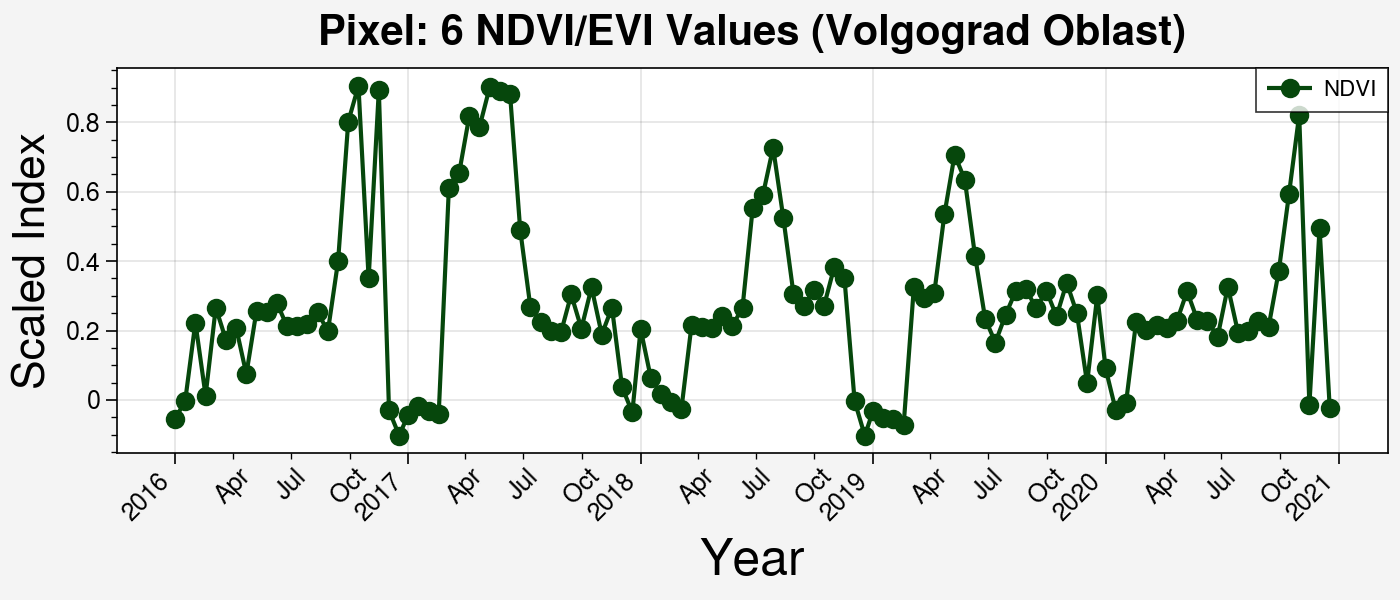

In [11]:
#plot
fig,ax = plot.subplots(figsize = (7,3),tight=True)
fig.suptitle('Pixel: '+ str(pixel_number) + ' NDVI/EVI Values (Volgograd Oblast)' ,fontsize = 15)
ax.plot(y_ndvi,x_ndvi,color = 'forest green',marker = 'o',label = 'NDVI')
#ax.plot(y_evi,x_evi,color ='red',marker = 'o',label = 'EVI')
fmt_q_year = mdates.MonthLocator(interval=3)
ax.xaxis.set_minor_locator(fmt_q_year)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
ax.format(xrotation = 45)
ax.tick_params(axis="x", which="minor", rotation=45)
plt.xlabel('Year',fontsize = 18)
plt.ylabel('Scaled Index', fontsize = 16)
plt.legend(prop = {'size':8})
plot.show()

In [11]:
pix_ndvi.describe()

id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,24,month,year
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,114.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,0.231681,0.354236,0.285375,0.307800,0.292963,0.272932,0.245468,0.315455,0.278823,0.254354,0.294836,0.294570,0.283137,0.286014,0.313664,0.248444,0.254900,0.252602,0.354219,0.267795,0.331750,0.272554,0.244932,0.312959,0.260582,6.330435,2018.000000
std,0.202730,0.261562,0.203388,0.188602,0.197724,0.247760,0.200571,0.256808,0.172679,0.183096,0.181603,0.251992,0.219926,0.197708,0.260051,0.219072,0.205307,0.236128,0.268809,0.246529,0.249564,0.286154,0.190794,0.281529,0.217592,3.440527,1.420403
min,-0.098400,-0.066700,-0.052800,-0.041200,-0.083000,-0.103000,-0.097200,-0.083200,-0.077900,-0.054900,-0.067500,-0.154500,-0.052200,-0.080900,-0.083200,-0.095000,-0.047300,-0.082500,-0.094100,-0.067300,-0.053200,-0.083900,-0.116100,-0.083300,-0.062900,1.000000,2016.000000
25%,0.141000,0.118650,0.214100,0.236650,0.171500,0.169050,0.181350,0.036600,0.216000,0.184750,0.230400,0.211450,0.164850,0.191100,0.210400,0.158950,0.177550,0.163100,0.186300,0.020000,0.190350,0.004000,0.174450,0.068600,0.179000,3.000000,2017.000000
50%,0.205900,0.358800,0.306800,0.324200,0.334300,0.231100,0.227900,0.294700,0.282000,0.222000,0.316800,0.255600,0.217400,0.296500,0.274500,0.219300,0.204600,0.212800,0.352700,0.244900,0.243700,0.234500,0.249500,0.254600,0.236700,6.000000,2018.000000
75%,0.305750,0.583650,0.420150,0.432750,0.425500,0.325300,0.313750,0.474750,0.371800,0.318700,0.410800,0.352675,0.430500,0.434600,0.394200,0.339900,0.255850,0.285150,0.546550,0.364650,0.476400,0.298950,0.337350,0.506900,0.343400,9.000000,2019.000000
max,0.759600,0.886000,0.809000,0.655600,0.766300,0.904900,0.902200,0.849800,0.727800,0.879400,0.804800,0.851900,0.882700,0.722600,0.885300,0.877400,0.813500,0.916100,0.874500,0.871900,0.923400,0.957700,0.745700,0.904000,0.873000,12.000000,2020.000000


In [16]:
pix_ndvi

id,Date,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,24,month,year
0,2016-01-01,-0.0198,-0.0140,-0.0132,-0.0338,-0.0362,-0.0558,-0.0329,0.0254,0.0102,-0.0549,-0.0275,0.0112,0.0049,-0.0535,-0.0231,-0.0376,-0.0437,-0.0280,-0.0038,-0.0140,-0.0532,-0.0028,0.0076,-0.0120,-0.0299,1,2016
1,2016-01-17,-0.0271,-0.0582,-0.0078,-0.0151,-0.0660,-0.0021,-0.0187,-0.0225,-0.0536,0.0005,-0.0336,-0.0238,-0.0132,-0.0205,-0.0267,-0.0950,-0.0242,-0.0181,-0.0123,-0.0489,-0.0159,-0.0288,-0.0301,-0.0277,-0.0247,1,2016
2,2016-02-02,-0.0026,0.0082,0.1316,0.2359,-0.0511,0.2230,-0.0208,-0.0120,0.2624,0.4905,0.2730,NaN,0.2337,-0.0387,-0.0070,0.0065,0.1743,0.3404,-0.0224,-0.0342,0.3726,-0.0551,-0.0546,-0.0424,-0.0129,2,2016
3,2016-02-18,0.0092,0.0121,0.0066,0.0139,0.0032,0.0124,0.0273,0.0132,0.2673,0.5887,0.0282,0.0281,0.0177,0.0094,0.0113,0.0366,0.0237,0.0040,0.0153,-0.0015,0.3020,-0.0004,0.0060,-0.0008,0.0042,2,2016
4,2016-03-05,0.2409,0.6081,0.4319,0.2874,0.3024,0.2660,0.2416,0.2507,0.2878,0.5720,0.2457,0.2097,0.2249,0.2664,0.2261,0.2385,0.1936,0.2356,0.2593,0.1909,0.3121,0.1573,0.2213,0.2089,0.2167,3,2016
5,2016-03-21,0.1572,0.3360,0.5049,0.2804,0.3465,0.1727,0.0839,0.1238,0.2225,0.4638,0.0276,0.2301,0.1974,0.4211,0.3247,0.2646,0.1924,0.1086,0.2440,0.1019,0.3206,0.2218,0.0197,-0.0097,0.2065,3,2016
6,2016-04-06,0.2751,0.6711,0.3898,0.4003,0.3343,0.2078,0.2214,0.2600,0.4371,0.6784,0.2322,0.2183,0.2174,0.4384,0.2557,0.2713,0.2149,0.2219,0.3007,0.2127,0.3917,0.2255,0.2423,0.2171,0.2204,4,2016
7,2016-04-22,0.2835,0.8552,0.6497,0.4154,0.4233,0.0742,0.3090,0.2752,0.6735,0.8080,0.2769,0.2319,0.2031,0.5217,0.2602,0.4773,0.2238,0.2208,0.3452,0.2348,0.7726,0.2834,0.2534,0.2210,0.3832,4,2016
8,2016-05-08,0.6072,0.8801,0.7009,0.5626,0.6256,0.2574,0.2787,0.3471,0.7278,0.8794,0.4543,0.2539,0.2187,0.6746,0.3346,0.8388,0.2467,0.2286,0.4287,0.4801,0.7271,0.2962,0.2861,0.5800,0.5996,5,2016
9,2016-05-24,0.6869,0.8860,0.8090,0.6139,0.7663,0.2520,0.2239,0.6928,0.6786,0.4922,0.8048,0.2892,0.4295,0.7226,0.2981,0.8310,0.2119,0.2707,0.5627,0.5915,0.8323,0.5594,0.2344,0.6382,0.6681,5,2016


In [12]:
#program for collecting and aggregating average ndvi at specific times of the year
#take into account winter mask
#do one with guard rails for months and one without 
##choose only peaks within certain months and one with no limits on where peaks
#needs to also only collect peaks that are above a certain threshold

#remove duplicates
def remove_duplicates(x):
    m = x.drop_duplicates('year')
    return m
pix_dup = remove_duplicates(pix_ndvi)
#initalize dataframe

#cycle through each season
for i in pix_dup.year:
    

SyntaxError: unexpected EOF while parsing (2654254569.py, line 14)

Select Year to view: 2018 
Select pixel (1-25): 12

Kurtosis for normal distribution : -0.9025040793518944

Kurtosis for normal distribution : 2.0974959206481056

Skewness:  0.49739299031007944

Max Pixel Value:  0.8206


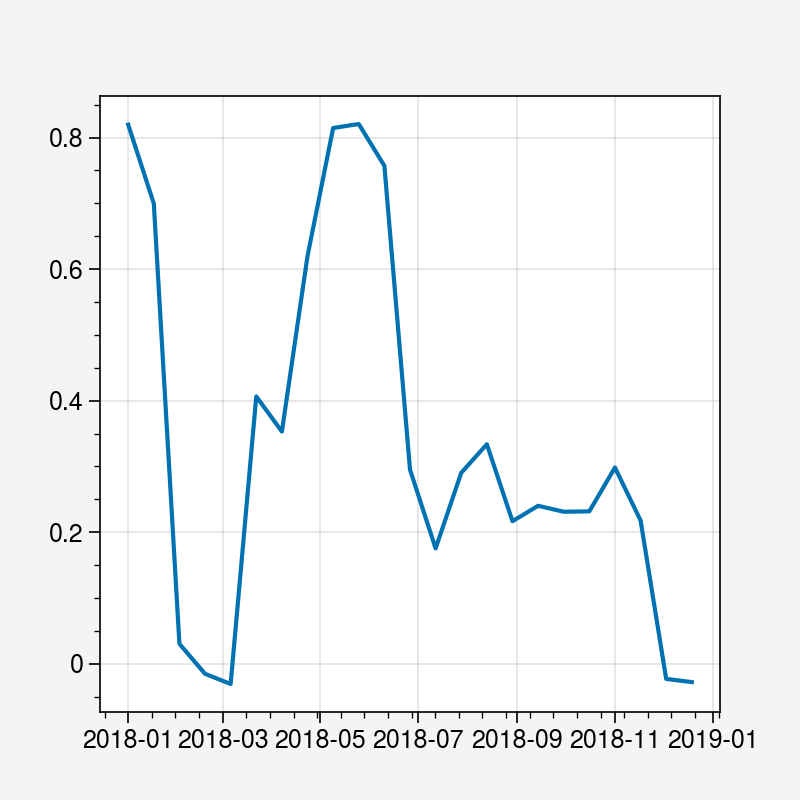

In [13]:
from scipy.stats import kurtosis, skew
import numpy as np 
import pylab as p
#isolate pixel and year
season = int(input('Select Year to view: '))
pixel = int(input('Select pixel (1-25): '))
sub_ndvi = pix_ndvi.loc[(pix_ndvi['year'] == season)]
y1 = sub_ndvi[pixel]
x1 = sub_ndvi['Date']
p.plot(x1, y1, '-')
print('\nKurtosis for normal distribution :', kurtosis(y1))
print('\nKurtosis for normal distribution :', kurtosis(y1, fisher = False))
print( '\nSkewness: ', skew(y1))
print( '\nMax Pixel Value: ', y1.max(skipna = True))

/opt/miniconda2/envs/gee/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


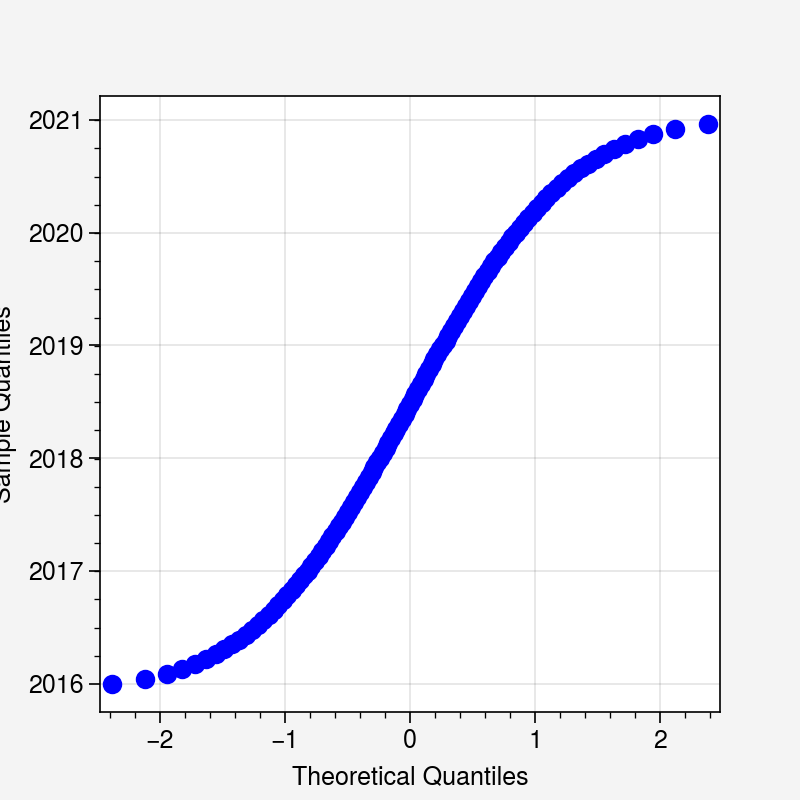

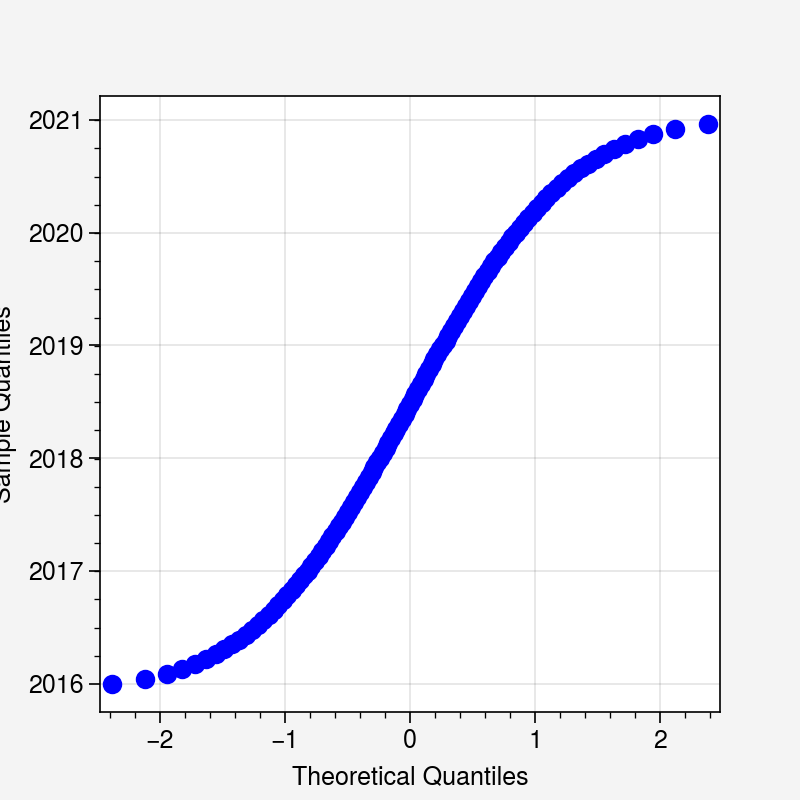

In [17]:
from statsmodels.graphics.gofplots import qqplot
qqplot(y_ndvi)

In [18]:
from scipy.stats import shapiro

stat, p = shapiro(y1)

In [19]:
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Sample does not look Gaussian (reject H0)
